
##Información del modelo

**Tipo:** Clasificación

**Descripción:** Este algoritmo busca predecir el estado actual de la pandemia en base a una clasificación de 3 niveles. Al algoritmo se le debe pasar un vector con distintos valores y este deberá arrojar el nivel de peligro que se predice.  

## Ejecución de librerías y carga de datos

Lo primero es instalar las librerías que son necesarias para el proyecto

In [1]:
#Instalo librerías que me van a ser útiles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from IPython.display import clear_output

In [6]:
#Librerías de Machine Learning
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

Lo siguiente es subir el aarchivo kaggle.json para poder descargar los archivos más adelante

In [7]:
#Importamos los archivos de colab
from google.colab import files

#Subimos el .json
files.upload() #buscan el archivo kaggle.json en su ordenador

#Reubicamos el .json y descargamos el set de datos
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Ahora descargamos el set de datos

In [9]:
#Se descarga el nuevo set de datos
!kaggle datasets download -d georgesaavedra/covid19-dataset

 55% 5.00M/9.09M [00:00<00:00, 38.6MB/s]
100% 9.09M/9.09M [00:00<00:00, 61.1MB/s]


Y lo descomprimimos

In [10]:
#Se descomprime
!unzip /content/covid19-dataset.zip

Archive:  /content/covid19-dataset.zip
  inflating: owid-covid-data.csv     


Ahora cargo el csv

In [11]:
dataset=pd.read_csv('owid-covid-data.csv')

## Preprocesamiento y selección de valores

Lo primero será establecer cuáles son las columnas con las que se va a trabajar, estas serán:

*   **Nuevos casos** (new_cases): Se usará este parámetro con el fin de conocer cómo son los nuevos contagios en el país.
*   **Nuevas muertes** (new_deaths): Se usará este parámetro con el fin de conocer cómo es la tasa de mortalidad de la enfermedad.
*   **Admisiones en UCI semanales** (	weekly_icu_admissions): Se usará este parámetro con el fin de conocer cómo es la relación de pacientes en UCI.
*   **Población** (population): Se usará este parámetro con el fin de aterrizar los anteriores valores dado el contexto del país.



In [13]:
#Ahora generamos el dataframe con la información que se necesita

#Primero elijo los datos que son obligatorios de reportar, estos serán el iso_code y la locación, es decir, el pais
cols_obligatory=["iso_code","continent","location"]

#Ahora elijo los datos con los que procesaré la información
cols_selected = ["new_cases","new_deaths","weekly_icu_admissions","population"]

#Ahora combino las columnas
cols=[]

for i in cols_obligatory:
  cols.append(i)

for i in cols_selected:
  cols.append(i)

#Ahora selecciono del dataset
myData=dataset.loc[:,cols]

#Ahora visualizo
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population
0,AFG,Asia,Afghanistan,5.0,NaN,NaN,39835428.0
1,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
2,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
3,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
4,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,NaN,15092171.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,NaN,15092171.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,NaN,15092171.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,NaN,15092171.0


Como se observa, falta información, por lo cual esta será llenada por ceros, pues se asumirá que ese día el registro no pudo ser tomado o aún no estaba siendo rastreado.

In [14]:
#Relleno la información de ceros
myData=myData.fillna(0)

#Ahora visualizo la información
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population
0,AFG,Asia,Afghanistan,5.0,0.0,0.0,39835428.0
1,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
2,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
3,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
4,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,0.0,15092171.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,0.0,15092171.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,0.0,15092171.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,0.0,15092171.0


Ahora lo siguiente es la construcción de variables auxiliares de clasificación, estas variables son:

---


**Porcentaje de nuevos casos**

Esta variable indica cuánto es el porcentaje de nuevos casos en relación a la población total.

Matemáticamente está definida como:
```
(Nuevos casos / Población)*100*1000
```

La clasificación de riesgo se hará bajo 3 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 20%.
*   **Riesgo moderado**: Si el valor está por encima del 5%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 5%.

Este parámetro indica cuánto es el porcentaje de la población que ha sido infectada. Se aplica una extrapolación debido a que se espera que sea un valor muy pequeño, es por ello que el porcentaje se eleva 1000 veces más.

---

**Porcentaje de mortalidad**

Esta variable indica cuánto es el porcentaje de nuevas muertes en base a los nuevos contagios.

Matemáticamente está definida como:
```
(Nuevas muertes / Nuevos casos)*100
```

La clasificación de riesgo se hará bajo 3 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 10%.
*   **Riesgo moderado**: Si el valor está por encima del 3%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 3%.

Este parámetro indica cuánto es el porcentaje de la población infectada que ha muerto.



**Peso de los parámetros:**

El nivel de clasificación general también será basado en 3 niveles, donde a mayor nivel es mayor el riesgo. Los anteriores valores tienen cierto peso para establecer el nivel de peligro. La ponderación es la siguiente:

1.   **Porcentaje de casos:** 33.3%
4.   **Porcentaje de UCI:** 33.3%
5.   **Porcentaje de mortalidad:** 33.3%


Ahora entonces se construye el dataset de procesamiento

In [15]:
#Genero el dataset de procesamiento
myProcess=pd.DataFrame()

#Ahora realizo los cálculos
myProcess["Infection_percent"]=(myData["new_cases"]/myData["population"])*100000
myProcess["Mortality_percent"]=(myData["new_deaths"]/myData["new_cases"])*100
#Relleno la información de la que no tengo valores
myProcess=myProcess.fillna(0)

#Observo
myProcess

,Infection_percent,Mortality_percent
0,0.012552,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
166321,3.253342,0.000000
166322,4.187602,0.158228
166323,0.000000,0.000000
166324,8.189677,0.080906


Lo siguiente entonces es rankear esta información según lo que necesito

In [16]:
#Porcentaje de contagios
mycol=pd.DataFrame()

#Obtengo la columna
mycol["Infection_percent"]=myProcess["Infection_percent"].copy()

#Ahora rankeo según el valor
mycol["Infection_percent"][mycol["Infection_percent"]<=5]=1
mycol[(mycol["Infection_percent"]<=20)&(mycol["Infection_percent"]>5)]=2
mycol[mycol["Infection_percent"]>20]=3

#Porcentaje de mortalidad

#Obtengo la columna
mycol["Mortality_percent"]=myProcess["Mortality_percent"]

#Ahora rankeo según el valor
mycol[mycol["Mortality_percent"]<=3]=1
mycol[(mycol["Mortality_percent"]<=10)&(mycol["Mortality_percent"]>3)]=2
mycol[mycol["Mortality_percent"]>10]=3

#Ahora visualizo de nuevo la tabla
mycol


,Infection_percent,Mortality_percent
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
166321,1.0,1.0
166322,1.0,1.0
166323,1.0,1.0
166324,1.0,1.0


In [17]:
#Visualizo la distribución de casos en general
print("Infection_percent")
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==1]))
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==2]))
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==3]))
print("\nMortality_percent")
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==1]))
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==2]))
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==3]))


Infection_percent
138997
20646
6683

Mortality_percent
138997
20646
6683


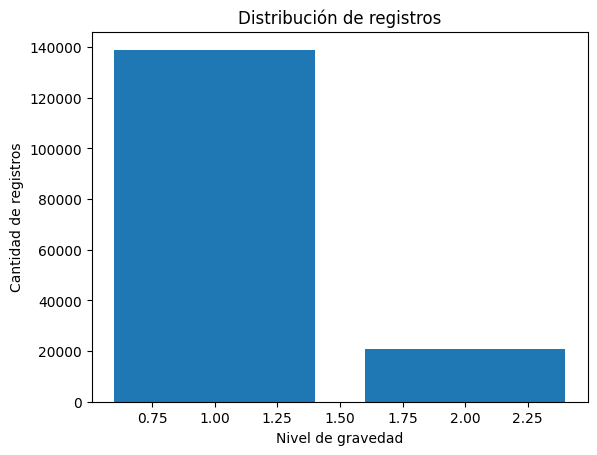

In [21]:
#Ploteo los casos de nuevos contagios
plt.bar([1,2],[len(mycol["Infection_percent"][mycol["Infection_percent"]==1]),len(mycol["Infection_percent"][mycol["Infection_percent"]==2])])
plt.xlabel("Nivel de gravedad")
plt.ylabel("Cantidad de registros")
plt.title("Distribución de registros")

plt.show()

Ahora queda generar la nueva variable, la cual será la ponderación de estos valores



In [22]:
#Aplico la operación
mycol["Result"]=round(mycol["Infection_percent"]*0.5+mycol["Mortality_percent"]*0.5)

#Ahora visualizo
mycol

,Infection_percent,Mortality_percent,Result
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
...,...,...,...
166321,1.0,1.0,1.0
166322,1.0,1.0,1.0
166323,1.0,1.0,1.0
166324,1.0,1.0,1.0


In [27]:
print("\nResult")
print(len(mycol[mycol["Result"]==1]))
print(len(mycol[mycol["Result"]==2]))
print(len(mycol[mycol["Result"]==3]))


Result
138997
20646
6683


Con la información obtenida entonces añado esta columna al dataset principal

In [28]:
#Añado la columna
myData["clasification"]=mycol["Result"]

#Visualizo
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population,clasification
0,AFG,Asia,Afghanistan,5.0,0.0,0.0,39835428.0,1.0
1,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
2,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
3,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
4,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
...,...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,0.0,15092171.0,1.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,0.0,15092171.0,1.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,0.0,15092171.0,1.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,0.0,15092171.0,1.0


## Construcción del set de entrenamiento y prueba

Debido al gran volumen de datos, el set se va a dividir en 3 partes, de la siguiente forma:

*   **Set de entrenamiento:** 70%
*   **Set de prueba:** 30%

Estos valores serán separados aleatoriamente por software, de esta forma se busca eliminar posibles problemas como el sesgo.

Voy a analizar el set de argentina

In [29]:
#Obtengo el dataset de Argentina
mySet=myData[myData["location"]=="Argentina"]

#Observo los resultados
print("\nResult")
print(len(mySet[mySet["clasification"]==1]))
print(len(mySet[mySet["clasification"]==2]))
print(len(mySet[mySet["clasification"]==3]))


Result
631
151
13


Como se observa, Argentina no llegó a los niveles críticos, por lo cual es necesario tomar datos de países aleatorios para poder realizar el entrenamiento. Se van a tomar 500 datos de cada tipo, es decir, 500 con clasificación de 1, 500 con clasificación de 2 y 500 con clasificación de 3.

In [30]:
#Tomo muestras aleatorias
clas_1=myData[myData["clasification"]==1].sample(500)
clas_2=myData[myData["clasification"]==2].sample(500)
clas_3=myData[myData["clasification"]==3].sample(500)

#Añado todo
mySet=pd.concat([clas_1,clas_2,clas_3])

#Lo revuelvo completamente
mySet=mySet.sample(frac = 1)

#Visualizo
mySet

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population,clasification
140993,ESP,Europe,Spain,1159.0,62.0,0.0,46745211.0,2.0
113319,NOR,Europe,Norway,24.0,0.0,0.0,5465629.0,1.0
75751,ITA,Europe,Italy,202.0,71.0,0.0,60367471.0,3.0
23962,BGR,Europe,Bulgaria,78.0,12.0,0.0,6896655.0,3.0
36244,HRV,Europe,Croatia,3.0,2.0,0.0,4081657.0,3.0
...,...,...,...,...,...,...,...,...
97587,MUS,Africa,Mauritius,0.0,0.0,0.0,1273428.0,1.0
75658,ITA,Europe,Italy,1797.0,97.0,0.0,60367471.0,2.0
120885,POL,Europe,Poland,241.0,8.0,0.0,37797000.0,2.0
43295,DOM,North America,Dominican Republic,295.0,0.0,0.0,10953714.0,1.0


Ahora sí entreno los valores

In [31]:
#Obtengo los valores que se ingresan
x=mySet.loc[:,["new_cases","new_deaths","weekly_icu_admissions","population"]].values

#Obtengo los resultados
y=mySet["clasification"]

In [32]:
#Verifico las formas
print(x.shape)
print(y.shape)

(1500, 4)
(1500,)


In [33]:
#Verifico que no haya datos nulos
print(np.any(np.isnan(x)),np.any(np.isnan(y)))

False False


In [34]:
#Verifico que todos los datos sean finitos
print(np.all(np.isfinite(x)),np.all(np.isfinite(y)))

True True


In [35]:
#Obtengo los datos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

## Construcción de los modelos

La arquitectura que se va a utilizar en estos modelos es la de máquina de soporte vectorial.

Se construye una rutina que evalúa distintas configuraciones según los parámetros de configuración usados.

In [36]:
#Parámetros de configuración
cmax=5
c_values=np.arange(1,cmax+0.1,0.1) #Genero los posibles valores que puede tomar C
gam=["auto","scale"]

#Parámetros de guardado
results=pd.DataFrame()
models={}

#Ahora genero los ciclos, primero recorro con C
for c_index in range(len(c_values)):

  #Obtengo el C a usar
  c_value=float(c_values[c_index])

  #Ahora recorro los gama
  for ga in gam:

    #Ahora genero el modelo con estas configuraciones
    clf = svm.SVC(C=float(c_value), gamma=ga)

    #Ahora lo entreno
    clf.fit(X_train,y_train)

    #Predigo las salidas
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    #Obtengo las matrices de confusión
    cm_train=confusion_matrix(y_train,predict_train)
    cm_test=confusion_matrix(y_test,predict_test)

    #Obtengo los reportes
    report_train=classification_report(y_train,predict_train, output_dict=True)
    report_test=classification_report(y_test,predict_test, output_dict=True)

    #Genero el diccionario que me guarda
    save={}
    save["C"]=c_value
    save["Gamma"]=ga
    save["Precision train"]=report_train['macro avg']['precision']
    save["Recall train"]=report_train['macro avg']['recall']
    save["F1-Score train"]=report_train['macro avg']['f1-score']
    save["Precision test"]=report_test['macro avg']['precision']
    save["Recall test"]=report_test['macro avg']['recall']
    save["F1-Score test"]=report_test['macro avg']['f1-score']

    #Ahora almaceno en el dataset
    results=results.append(save,ignore_index=True)

    #Ahora almaceno el modelo
    name=str(c_value)+"_"+str(ga)

    #Ahora guardo el modelo
    mymodel={}
    mymodel["Model"]=clf
    mymodel["cm_train"]=cm_train
    mymodel["cm_test"]=cm_test

    models[name]=mymodel


#Limpio la consola
clear_output()

#Imprimo los resultados
results


,C,Gamma,Precision train,Recall train,F1-Score train,Precision test,Recall test,F1-Score test
0,1.0,auto,0.996260,0.996260,0.996255,0.648795,0.468516,0.419934
1,1.0,scale,0.652348,0.380062,0.264211,0.450030,0.361288,0.228724
2,1.1,auto,0.996260,0.996260,0.996255,0.633451,0.468789,0.421049
3,1.1,scale,0.652348,0.380062,0.264211,0.450030,0.361288,0.228724
4,1.2,auto,0.996260,0.996260,0.996255,0.633451,0.468789,0.421049
...,...,...,...,...,...,...,...,...
77,4.8,scale,0.442709,0.373977,0.314090,0.397165,0.359857,0.290034
78,4.9,auto,1.000000,1.000000,1.000000,0.665835,0.478017,0.435773
79,4.9,scale,0.442709,0.373977,0.314090,0.397165,0.359857,0.290034
80,5.0,auto,1.000000,1.000000,1.000000,0.665835,0.478017,0.435773


Ahora se elige el mejor modelo de forma sintética

In [37]:
#Los ordeno entre mejores parámetros
sorted=results.sort_values(["Precision train","Precision test","F1-Score train","F1-Score test","Recall test","Recall train"],ascending=[False,False,False,False,False,False])

#Obtengo la mejor combinación
best=sorted.head(1)

#Obtengo el name
name=str(best.loc[:,["C"]].values[0][0])+"_"+str(best.loc[:,["Gamma"]].values[0][0])

#Visualizo la mejor
best


,C,Gamma,Precision train,Recall train,F1-Score train,Precision test,Recall test,F1-Score test
50,3.5,auto,1.0,1.0,1.0,0.665835,0.478017,0.435773


Ahora visualizo las matrices de confusión


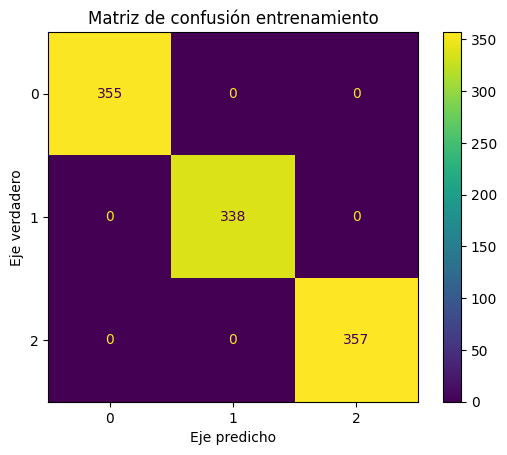

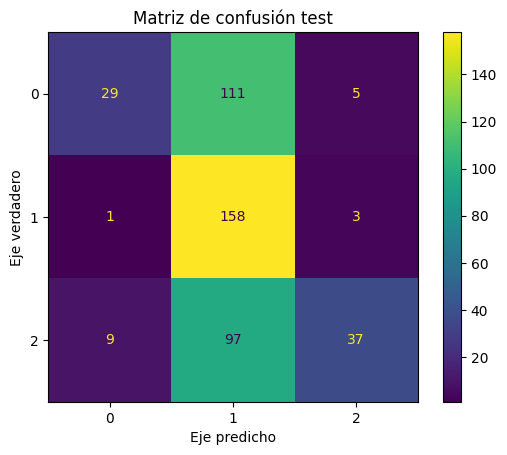

In [38]:
#Hago el plot para el entrenamiento
mimatriz=models[name]["cm_train"]
cm_display = ConfusionMatrixDisplay(confusion_matrix = mimatriz)

#Ploteo
cm_display.plot()
plt.title("Matriz de confusión entrenamiento")
plt.xlabel("Eje predicho")
plt.ylabel("Eje verdadero")
plt.show()

#Hago el plot para el testeo
mimatriz=models[name]["cm_test"]
cm_display = ConfusionMatrixDisplay(confusion_matrix = mimatriz)

#Ploteo
cm_display.plot()
plt.title("Matriz de confusión test")
plt.xlabel("Eje predicho")
plt.ylabel("Eje verdadero")
plt.show()

In [39]:
#Ahora lo salvo 2
np.save("data_svm.npy", {"Model":name,"Model_file":models[name],"All data":[x,y],"Train":[X_train,y_train],"Test":[X_test,y_test]})

In [40]:
    #Ahora genero el modelo con estas configuraciones
    clf = svm.SVC(C=float(1.3), gamma="auto")

    #Ahora lo entreno
    clf.fit(X_train,y_train)

    #Predigo las salidas
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

In [41]:
#Curva de aprendizaje
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Genera 3 graficas: La curva de prueba y la curva de aprendizaje, los datos
    de entrenamiento vs la curva de tiempos de ajuste, la curva de tiempos de
    ajuste frente a la puntuación.

    Parameters
    ----------
    estimator : instancia de estimador. Una instancia de estimador que implementa los métodos `fit` y `predict`
    que se clonará para cada validación.

    title : str

    X : array-like de tamaño (n_samples, n_features)
        vector de entrenamiento, donde``n_samples``es el numero de muestras y ``n_features`` es
        el número de caracteristicas.

    y : array-like de tamaño (n_samples) o (n_samples, n_features)
        Objetivo relativo a ``X`` para la clasificación o la regresión;

    axes : array-like de tamañoe (3,), default=None
        Se implementa para la grafica de la curva.

    ylim : tuple de tamaño (2,), default=None

    cv : int, generador de validación cruzada o un iterable, por defecto=None
        Determina la estrategia de división de la validación cruzada.
        Las entradas posibles para cv son:

          - None, para utilizar la validación cruzada de 5 pliegues por defecto,
          - Entero, para especificar el número de pliegues.
          - Un iterable que produce divisiones (tren, prueba) como matrices de índices.

    n_jobs : int o None, por defecto=None
        Número de trabajos a ejecutar en paralelo.

    scoring : str or callable, default=None

    train_sizes : tipo array de forma (n_ticks,)
        Números relativos o absolutos de muestras de entrenamiento que se utilizarán para
        generar la curva de aprendizaje. Si el ``dtype`` es float, se considera
        como una fracción del tamaño máximo del conjunto de entrenamiento (que es
        (determinado por el método de validación seleccionado), es decir, tiene que estar dentro de
        (0, 1]. En caso contrario, se interpreta como el tamaño absoluto de los conjuntos de
        de los conjuntos de entrenamiento. Tenga en cuenta que, para la clasificación, el número de muestras
        suele ser lo suficientemente grande como para contener al menos una muestra de cada clase.
        (por defecto: np.linspace(0.1, 1.0, 5))
    """
    #Se estable los axes
    if axes is None:
        _, axes = plt.subplots(1, figsize=(10, 10))


    axes.set_title(title)
    #Se establece y lim
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    #Se genera la curva de aprendizaje
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Grafico de la curva de aprendizaje
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    #Se retorna el grafico de la curva de aprendizaje
    return plt

In [42]:
from sklearn.model_selection import learning_curve


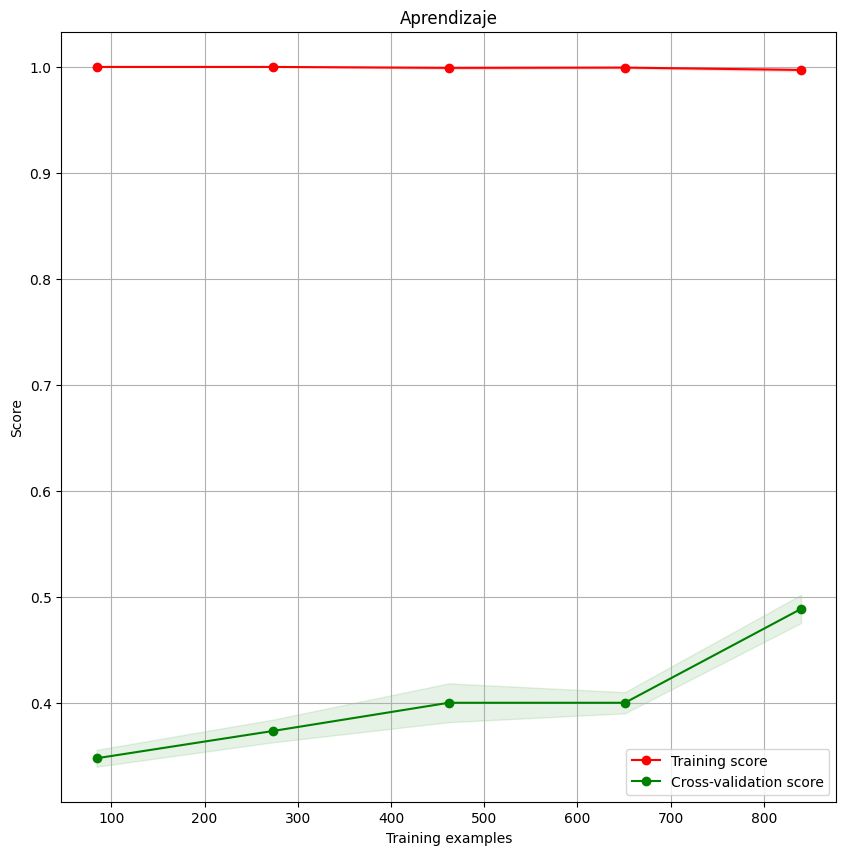

In [43]:
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=clf ,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()